# Reproducing the Results of the Paper

## Importing Libraries

In [1]:
!pip install bayesian-optimization
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from bayes_opt import BayesianOptimization
from tensorflow.python.keras.optimizer_v2 import rmsprop

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Data Preprocessing

In [2]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

170498071/170498071 [==============================] - 9s 0us/step


## Method 1: Conv Net + Max Pooling

In [3]:
# Method 1: Conv Net + Max Pooling 
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 512)               2

## Method 2: Conv Net + Max Pooling (Bayesian Optimization)

In [4]:
def get_model(hidden_units, kernel_size, pool_size):
    # Reset the tensorflow backend session.
    # tf.keras.backend.clear_session()
    # Define a CNN model to recognize CIFAR-10.
    
    hidden_units = int(hidden_units)
    kernel_size = int(kernel_size)
    pool_size = int(pool_size)
    
    model = Sequential([
    Conv2D(hidden_units, (kernel_size, kernel_size), activation='relu', padding='same', ),
    Conv2D(hidden_units, (kernel_size, kernel_size), activation='relu', padding='same'),
    MaxPooling2D((pool_size, pool_size)),
    Conv2D(hidden_units, (kernel_size, kernel_size), activation='relu', padding='same'),
    Conv2D(hidden_units, (kernel_size, kernel_size), activation='relu', padding='same'),
    MaxPooling2D((pool_size, pool_size)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
    ])
    
    return model

In [5]:
def fit_with(hidden_units, kernel_size, pool_size):
    # Create the model using a specified hyperparameters.
    model = get_model(hidden_units, kernel_size, pool_size)

    # Train the model for a specified number of epochs.
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

    # Train the model with the train dataset.
    model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(x_test, y_test, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Return the accuracy.
    return score[1]

In [6]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'hidden_units': (32, 64), 
           'kernel_size': (2, 3), 
           'pool_size': (2, 3)}

optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)
optimizer.maximize(init_points=4, n_iter=2,)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   | hidden... | kernel... | pool_size |
-------------------------------------------------------------
Test loss: 1.1345949172973633
Test accuracy: 0.6007999777793884
| 1         | 0.6008    | 45.34     | 2.72      | 2.0       |
Test loss: 1.1587748527526855
Test accuracy: 0.5867000222206116
| 2         | 0.5867    | 41.67     | 2.147     | 2.092     |
Test loss: 1.2913161516189575
Test accuracy: 0.5580999851226807
| 3         | 0.5581    | 37.96     | 2.346     | 2.397     |
Test loss: 1.1428139209747314
Test accuracy: 0.598800003528595
| 4         | 0.5988    | 49.24     | 2.419     | 2.685     |
Test loss: 1.097665786743164
Test accuracy: 0.628000020980835
| 5         | 0.628     | 56.92     | 3.0       | 2.0       |
Test loss: 1.0955055952072144
Test accuracy: 0.620199978351593
| 6         | 0.6202    | 62.45     | 3.0       | 2.0       |
Iteration 0: 
	{'target': 0.6007999777793884, 'params': {'hidden_units': 45.34470415048237, 'kernel_size': 2.720324493442158

In [7]:
bestHP = optimizer.max['params']
hidden_units = int(bestHP['hidden_units'])
kernel_size = int(bestHP['kernel_size'])
pool_size = int(bestHP['pool_size'])
model2 = get_model(hidden_units, kernel_size, pool_size)

## Method 3: Conv Net + Max Pooling + Dropout in Fully Connected Layers

In [8]:
# Method 3: Conv Net + Max Pooling + Dropout in Fully Connected Layers
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

## Method 4: Conv Net + Max Pooling + Dropout in All Layers

In [9]:
# Method 4: Conv Net + Max Pooling + Dropout in All Layers
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

## Method 5: Conv Net + Maxout 

In [10]:
import tensorflow_addons as tfa

# Method 5: Conv Net + Maxout 
model5 = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), padding='same'),
    Conv2D(512, (3, 3), padding='same'),
    Flatten(),
    Dense(512),
    tfa.layers.Maxout(256),
    Dense(10, activation='softmax')
])
model5.summary()

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 512)       

In [11]:
# Compile and train the models
history = []
models = [model1, model2, model3, model4, model5]
for model in models:
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    h = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), verbose=0)
    history.append(h)

# Evaluate the models
test_loss = []
test_acc = []
for model in models:
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    test_loss.append(loss)
    test_acc.append(acc)

2023-06-09 07:56:32.590730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


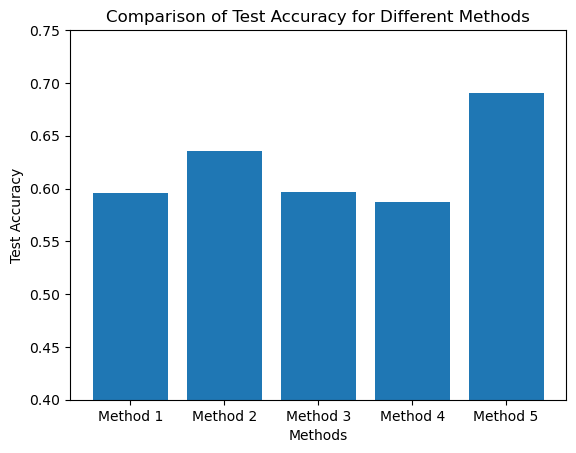

In [12]:
# Plot the comparison of test accuracy for each method
plt.bar(range(5), test_acc)
plt.xticks(range(5), ['Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5'])
plt.xlabel('Methods')
plt.ylabel('Test Accuracy')
plt.ylim([0.4, 0.75])
plt.title('Comparison of Test Accuracy for Different Methods')
plt.savefig('Test Accuracy of Each Methods.png')
plt.show()

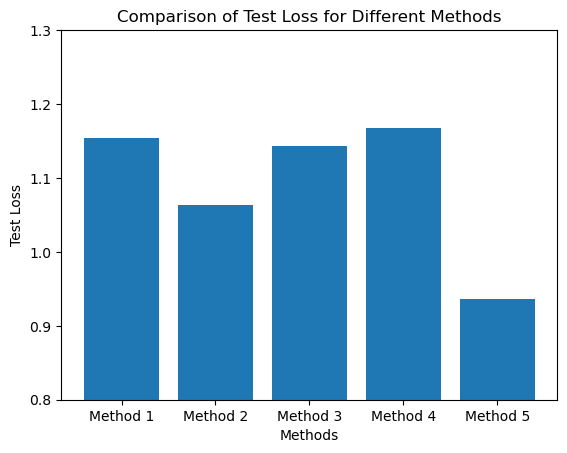

In [13]:
# Plot the comparison of test accuracy for each method
plt.bar(range(5), test_loss)
plt.xticks(range(5), ['Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5'])
plt.xlabel('Methods')
plt.ylabel('Test Loss')
plt.ylim([0.8, 1.3])
plt.title('Comparison of Test Loss for Different Methods')
plt.savefig('Test Loss of Each Methods.png')
plt.show()

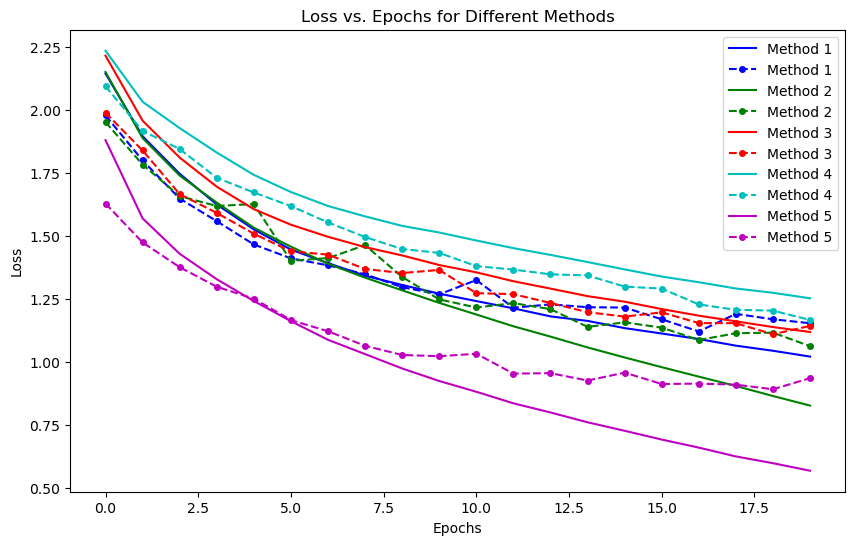

In [14]:
# Plot the loss vs. epoch curves for each method
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(10, 6))
for i, h in enumerate(history):
    plt.plot(h.history['loss'], label=f'Method {i+1}', color=colors[i])
    plt.plot(h.history['val_loss'], label=f'Method {i+1}', color=colors[i], marker='o', markersize=4, linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs for Different Methods')
plt.legend()
plt.savefig('Loss vs. Epochs.png')
plt.show()

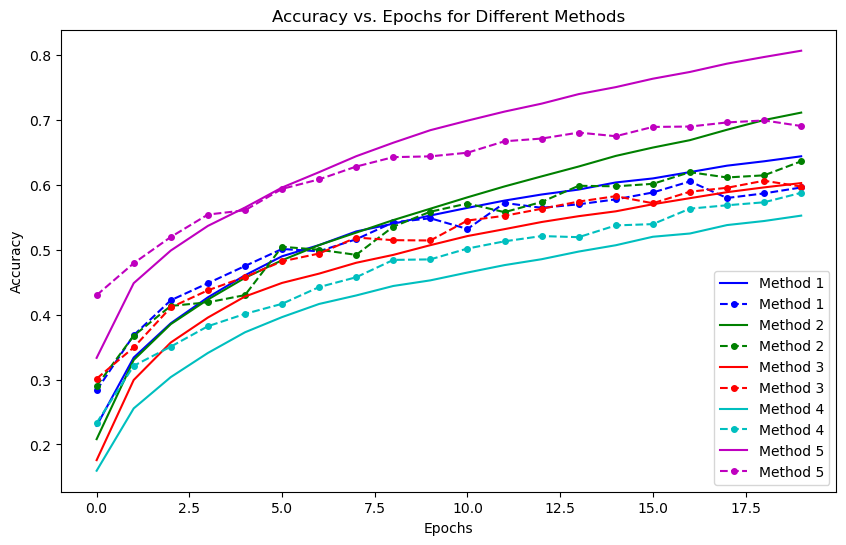

In [15]:
# Plot the accuracy vs. epoch curves for each method
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(10, 6))
for i, h in enumerate(history):
    plt.plot(h.history['accuracy'], label=f'Method {i+1}', color=colors[i])
    plt.plot(h.history['val_accuracy'], label=f'Method {i+1}', color=colors[i], marker='o', markersize=4, linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs for Different Methods')
plt.legend()
plt.savefig('Accuracy vs. Epochs.png')
plt.show()

In [16]:
import json
import pandas as pd

for i, model_history in enumerate(history, start=1):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame.from_dict(model_history.history)

    # save to json:  
    hist_json_file = f'history{i}.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = f'history{i}.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)